## Cycle-by-cycle Tutorial

The code used in this script is modified from https://bycycle-tools.github.io/bycycle/auto_tutorials/index.html

This method takes in a 1-dimensional time series of preprocessed electrophysiological data. A dataframe containing the characteristics (timing, frequency, power, etc.) of each detected burst is returned. 

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import scipy.io as io
from bycycle import Bycycle
from bycycle.cyclepoints import find_extrema, find_zerox
from bycycle.cyclepoints.zerox import find_flank_zerox
from bycycle.plts import plot_cyclepoints_array
from bycycle.utils.download import load_bycycle_data
from papto_functions import * 

/export03/data/lindseyp/burst_methods_review/papto_functions.py:24: DeprecationWarning: 
The `fooof` package is being deprecated and replaced by the `specparam` (spectral parameterization) package.
This version of `fooof` (1.1) is fully functional, but will not be further updated.
New projects are recommended to update to using `specparam` (see Changelog for details).
  from fooof import FOOOF


In [2]:
#  Read in one-dimensional time series (preprocessed)
file_name = 'sub-0002_SomMotA_4_R.mat'
scout_mean_timecourses = io.loadmat(file_name)
data = np.squeeze(scout_mean_timecourses['Value'])

print(data.shape)

(150000,)


### 1. Set Model Parameters

Several parameters must be selected for the cycle-by-cycle method. Burst-like cycles are defined by their amplitude consistency, periodicity, monotinicity, and number of cycles. Therefore, thresholds must be selected for each of these charactersitics. 

Information about the definition of these parameters can be found at https://github.com/bycycle-tools/ and in Cole & Voytek, 2019 (https://doi.org/10.1152/jn.00273.2019)

In [23]:
# Set parameters 
Fs  = 250.0
f_beta = (15,30)

thresholds = {
    'amp_fraction': 0.3,
    'amp_consistency': 0.1,
    'period_consistency': 0.5,
    'monotonicity': 0.8,
    'min_n_cycles': 3
}

### 2. Run Cycle-by-Cycle 

The cycle-by-cycle algorithm is a fully-integrated python package and therefore does not require manual processing steps or locally-stored utility functions. Creating a Bycycle object and fitting it to the data outputs a dataframe containing information about every cycle identified in the data, including an 'is_burst' tag, allowing us to identify which cycles are part of a burst event. 

For more information on the specific processing steps completed by the Bycycle package see https://github.com/bycycle-tools/ 

In [24]:
# Call the cyclebycycle function
bm = Bycycle(thresholds=thresholds)
bm.fit(data, Fs, f_beta)

# Extract only the cycles that are part of a burst
burst_df = bm.df_features
burst_df = burst_df[burst_df['is_burst']==True]

burst_df.head(5)

,amp_fraction,amp_consistency,period_consistency,monotonicity,period,time_peak,time_trough,volt_peak,volt_trough,time_decay,...,time_rdsym,time_ptsym,band_amp,sample_peak,sample_last_zerox_decay,sample_zerox_decay,sample_zerox_rise,sample_last_trough,sample_next_trough,is_burst
24,0.963016,0.177233,0.529412,1.000,17,10,5,1.211911,-4.087637,8,...,0.529412,0.666667,0.931173,306,294,309,299,297,314,True
25,0.596667,0.119958,0.529412,0.875,9,3,8,-0.315045,-0.643968,5,...,0.444444,0.272727,0.853592,318,309,320,317,314,323,True
26,0.928175,0.384336,0.600000,1.000,15,7,8,1.491953,-3.057036,6,...,0.600000,0.466667,1.047824,332,320,335,328,323,338,True
27,0.734206,0.354206,0.666667,1.000,10,5,5,0.783757,-0.256388,5,...,0.500000,0.500000,1.044580,343,335,345,340,338,348,True
28,0.917857,0.451858,0.666667,0.900,15,8,7,2.052839,-2.152801,5,...,0.666667,0.533333,0.787666,358,345,360,352,348,363,True


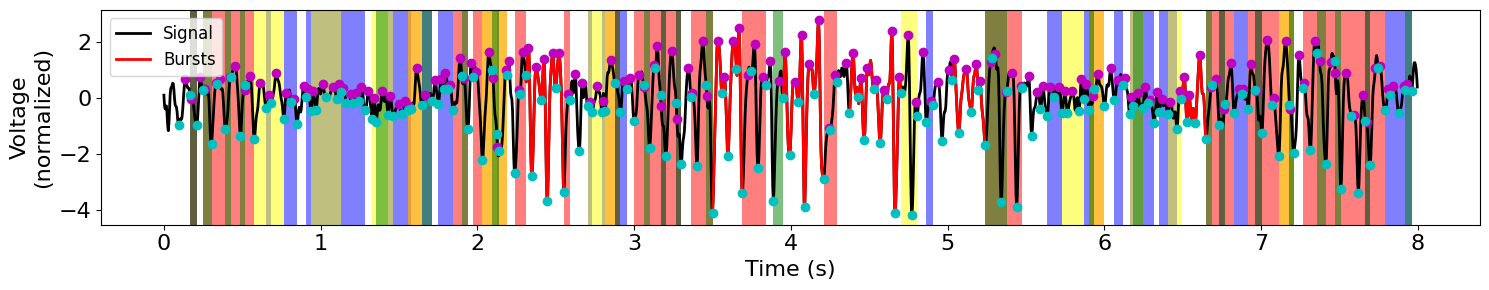

In [25]:
# View a short segment of the data indicating where burst-like cycles were identified 
data_crop = data[66500:68500]
bm_crop = Bycycle(thresholds=thresholds)
bm_crop.fit(data_crop, Fs, f_beta)
bm_crop.plot(xlim=(0,8),plot_only_results=True)

# Blue shading violates amplitude fraction threshold 
# Red shading violates amplitude consistency threshold 
# Yellow shading violates period consistency threshold 
# Green shading violates monotonicity threshold 

### 3. Identify and Summarize Bursts 

Although the Bycycle package returns information about whether every cycle is part of a burst, it does not return summary statistics about multi-cycle bursts as we see with other burst detection methods. For that reason, we must identify consecutive "burst-like" cycles and create a summary of multi-cycle bursts using the information provided in the 'df_features' dataframe. 

In [26]:
burst_summary_df = []
i = 0 

# Loop through the cycles that were identified as being part of a burst and group adjacent cycles together 
# Gives one instance per burst event, similar to other methods 
while i<(len(burst_df)-1):
    curr_sample_next_trough = 0
    next_sample_last_trough = 0
    curr_burst = []
    while curr_sample_next_trough==next_sample_last_trough and i<(len(burst_df)-1):
        curr_sample = burst_df.iloc[[i]]
        next_sample = burst_df.iloc[[i+1]]
        curr_sample_next_trough = curr_sample['sample_next_trough'].tolist()[0]
        next_sample_last_trough = next_sample['sample_last_trough'].tolist()[0]

        curr_burst.append(curr_sample)
        i=i+1
    
    # Calculate summary characteristics for the current burst 
    curr_burst_df = pd.concat(curr_burst)
    num_cycles = len(curr_burst_df)
    burst_onset = curr_burst_df.iloc[[0]]['sample_last_trough'].tolist()[0]
    burst_offset = curr_burst_df.iloc[[-1]]['sample_next_trough'].tolist()[0]
    duration = burst_offset - burst_onset
    avg_period = np.mean(curr_burst_df['period'])
    avg_frequency = 1/(avg_period/Fs)
    
    if len(curr_burst_df)%2==0:
        center_ind = (num_cycles/2)-1
        peak_time = curr_burst_df.iloc[[center_ind]]['sample_next_trough'].tolist()[0]
    else: 
        center_ind = (round(num_cycles/2))-1
        peak_time = curr_burst_df.iloc[[center_ind]]['sample_peak'].tolist()[0]

    curr_burst_dict = {'Event Onset Time': burst_onset/Fs, 'Event Offset Time': burst_offset/Fs, 'Event Duration': duration/Fs,
                        'Peak Frequency': avg_frequency, 'Peak Time': peak_time/Fs, 'Number of Cycles': num_cycles}
    burst_summary_df.append(curr_burst_dict)

# Create a dataframe from the summary events 
burst_summary_df = pd.DataFrame(burst_summary_df)
burst_summary_df.head(5)

,Event Onset Time,Event Offset Time,Event Duration,Peak Frequency,Peak Time,Number of Cycles
0,1.188,1.588,0.400,20.000000,1.392,8
1,1.864,2.028,0.164,18.292683,1.928,3
2,2.812,3.020,0.208,19.230769,2.916,4
3,4.528,4.784,0.256,19.531250,4.596,5
4,4.972,5.116,0.144,20.833333,5.044,3


In [27]:
# Record burst rate 
burstRate = burst_summary_df.shape[0]/(data.shape[0]/Fs)
print("Burst Rate:")
print(burstRate)

Burst Rate:
0.8


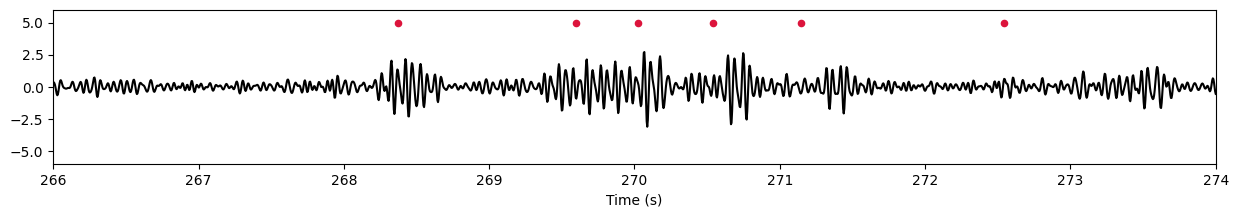

In [28]:
# Plot indication of burst peak times with respect to raw (bandpassed) time series - for comparison to other methods 
fig = plt.figure(figsize=(15,2))
scale_val = 20
beta_filt_dat = mne.filter.filter_data(np.squeeze(data), Fs, l_freq=15.0, h_freq=30.0,verbose=False)
times = np.arange(0,data.shape[0])/Fs
plt.plot(times,beta_filt_dat,zorder=0,c='black')
plt.scatter(burst_summary_df['Peak Time'], [5]*len(burst_summary_df['Peak Time']) ,c='crimson',s=scale_val,zorder=1)
plt.ylim(-6,6)
plt.xlim(266,274)
plt.xlabel('Time (s)')

plt.show()

In [31]:
burst_summary_df.to_csv('cyclebycycle_bursts.csv')